In [1]:
# モジュールのインポート
import numpy as np
import pandas as pd
import pandas_datareader.data as data
from matplotlib import pyplot as plt
%matplotlib inline

# 週を追加
from datetime import datetime
from datetime import timedelta

# 標準化関数（StandardScaler）をインポート
from sklearn.preprocessing import StandardScaler

# LSTM
# !pip install tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

# 時系列分割のためTimeSeriesSplitのインポート
from sklearn.model_selection import TimeSeriesSplit
# accuracy算出のためためaccuracy_scoreのインポート
from sklearn.metrics import accuracy_score

# 混同行列生成のための混同行列生成のためのconfusion_matrixをインポート
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
start = '2005-01-01'
end = '2022-01-01'

df = data.DataReader('AAPL.US', 'stooq', start, end) 
df.to_csv('Z_Holdings.csv')

In [3]:
# データの確認
df = pd.read_csv('Z_Holdings.csv')
df

,Date,Open,High,Low,Close,Volume
0,2021-12-31,178.0850,179.2300,177.2600,177.5700,64062261
1,2021-12-30,179.4700,180.5700,178.0900,178.2000,59773014
2,2021-12-29,179.3300,180.6300,178.1400,179.3800,62348931
3,2021-12-28,180.1600,181.3300,178.5300,179.2900,79144339
4,2021-12-27,177.0850,180.4200,177.0700,180.3300,74919582
...,...,...,...,...,...,...
4275,2005-01-07,0.9958,1.0658,0.9916,1.0601,2607118863
4276,2005-01-06,0.9921,0.9935,0.9693,0.9881,822930454
4277,2005-01-05,0.9788,0.9988,0.9788,0.9875,793814983
4278,2005-01-04,0.9760,1.0023,0.9640,0.9788,1280464965


In [4]:
# カラムのデータ型の確認、欠損値の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4280 non-null   object 
 1   Open    4280 non-null   float64
 2   High    4280 non-null   float64
 3   Low     4280 non-null   float64
 4   Close   4280 non-null   float64
 5   Volume  4280 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 200.8+ KB


In [5]:
# Dateデータがobject型なので、datatime64型へ変更（利便性が高いため）
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4280 non-null   datetime64[ns]
 1   Open    4280 non-null   float64       
 2   High    4280 non-null   float64       
 3   Low     4280 non-null   float64       
 4   Close   4280 non-null   float64       
 5   Volume  4280 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 200.8 KB


In [6]:
# 曜日情報の追加（月曜日:0, 火曜日:1, 水曜日:2, 木曜日:3, 金曜日:4, 土曜日:5, 日曜日:6）
df['weekday'] = df['Date'].dt.weekday
df

,Date,Open,High,Low,Close,Volume,weekday
0,2021-12-31,178.0850,179.2300,177.2600,177.5700,64062261,4
1,2021-12-30,179.4700,180.5700,178.0900,178.2000,59773014,3
2,2021-12-29,179.3300,180.6300,178.1400,179.3800,62348931,2
3,2021-12-28,180.1600,181.3300,178.5300,179.2900,79144339,1
4,2021-12-27,177.0850,180.4200,177.0700,180.3300,74919582,0
...,...,...,...,...,...,...,...
4275,2005-01-07,0.9958,1.0658,0.9916,1.0601,2607118863,4
4276,2005-01-06,0.9921,0.9935,0.9693,0.9881,822930454,3
4277,2005-01-05,0.9788,0.9988,0.9788,0.9875,793814983,2
4278,2005-01-04,0.9760,1.0023,0.9640,0.9788,1280464965,1


In [7]:
# 初めの月曜日として3/21を基準に週を追加 timedelta (날짜구하는 함수)
start = datetime(2005,3,21)
df['weeks'] = (df['Date'] - start) // timedelta(weeks=1) 
df

,Date,Open,High,Low,Close,Volume,weekday,weeks
0,2021-12-31,178.0850,179.2300,177.2600,177.5700,64062261,4,875
1,2021-12-30,179.4700,180.5700,178.0900,178.2000,59773014,3,875
2,2021-12-29,179.3300,180.6300,178.1400,179.3800,62348931,2,875
3,2021-12-28,180.1600,181.3300,178.5300,179.2900,79144339,1,875
4,2021-12-27,177.0850,180.4200,177.0700,180.3300,74919582,0,875
...,...,...,...,...,...,...,...,...
4275,2005-01-07,0.9958,1.0658,0.9916,1.0601,2607118863,4,-11
4276,2005-01-06,0.9921,0.9935,0.9693,0.9881,822930454,3,-11
4277,2005-01-05,0.9788,0.9988,0.9788,0.9875,793814983,2,-11
4278,2005-01-04,0.9760,1.0023,0.9640,0.9788,1280464965,1,-11


In [8]:
# 理解しやすいようにカラムの並び替えを行います。
df = df[['Date', 'weeks', 'weekday', 'High', 'Low', 'Open', 'Close']]
df

,Date,weeks,weekday,High,Low,Open,Close
0,2021-12-31,875,4,179.2300,177.2600,178.0850,177.5700
1,2021-12-30,875,3,180.5700,178.0900,179.4700,178.2000
2,2021-12-29,875,2,180.6300,178.1400,179.3300,179.3800
3,2021-12-28,875,1,181.3300,178.5300,180.1600,179.2900
4,2021-12-27,875,0,180.4200,177.0700,177.0850,180.3300
...,...,...,...,...,...,...,...
4275,2005-01-07,-11,4,1.0658,0.9916,0.9958,1.0601
4276,2005-01-06,-11,3,0.9935,0.9693,0.9921,0.9881
4277,2005-01-05,-11,2,0.9988,0.9788,0.9788,0.9875
4278,2005-01-04,-11,1,1.0023,0.9640,0.9760,0.9788


In [9]:
# データの並び替え（sort_valuesで日付順に並び替えを行う）
df.sort_values(by='Date', ascending=True, inplace=True)

# 日付のDateをインデックスにセット（今回のような時系列データを処理する際はset_indexを使用して日付をインデックスに設定）
df.set_index(keys="Date", inplace=True)
df

/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,weeks,weekday,High,Low,Open,Close
Date,,,,,,
2005-01-03,-11,0,0.9967,0.9585,0.9930,0.9687
2005-01-04,-11,1,1.0023,0.9640,0.9760,0.9788
2005-01-05,-11,2,0.9988,0.9788,0.9788,0.9875
2005-01-06,-11,3,0.9935,0.9693,0.9921,0.9881
2005-01-07,-11,4,1.0658,0.9916,0.9958,1.0601
...,...,...,...,...,...,...
2021-12-27,875,0,180.4200,177.0700,177.0850,180.3300
2021-12-28,875,1,181.3300,178.5300,180.1600,179.2900
2021-12-29,875,2,180.6300,178.1400,179.3300,179.3800


In [10]:
# カラム情報を1行上にずらしたフレームワークを作成します。（カラムの情報を一行上に） -> 컬럼 정보를 1행 위로 이동한 DF
df_shift = df.shift(-1)
df_shift

,weeks,weekday,High,Low,Open,Close
Date,,,,,,
2005-01-03,-11.0,1.0,1.0023,0.9640,0.9760,0.9788
2005-01-04,-11.0,2.0,0.9988,0.9788,0.9788,0.9875
2005-01-05,-11.0,3.0,0.9935,0.9693,0.9921,0.9881
2005-01-06,-11.0,4.0,1.0658,0.9916,0.9958,1.0601
2005-01-07,-10.0,0.0,1.0825,1.0392,1.0701,1.0559
...,...,...,...,...,...,...
2021-12-27,875.0,1.0,181.3300,178.5300,180.1600,179.2900
2021-12-28,875.0,2.0,180.6300,178.1400,179.3300,179.3800
2021-12-29,875.0,3.0,180.5700,178.0900,179.4700,178.2000


In [11]:
# 翌日の終値と本日の終値の差分を追加する
df['delta_Close'] = df_shift['Close'] - df['Close']
df

/var/folders/g5/jlzp3hhs653_qdq2kmf35jbh0000gn/T/ipykernel_60730/4001850588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_Close'] = df_shift['Close'] - df['Close']


,weeks,weekday,High,Low,Open,Close,delta_Close
Date,,,,,,,
2005-01-03,-11,0,0.9967,0.9585,0.9930,0.9687,0.0101
2005-01-04,-11,1,1.0023,0.9640,0.9760,0.9788,0.0087
2005-01-05,-11,2,0.9988,0.9788,0.9788,0.9875,0.0006
2005-01-06,-11,3,0.9935,0.9693,0.9921,0.9881,0.0720
2005-01-07,-11,4,1.0658,0.9916,0.9958,1.0601,-0.0042
...,...,...,...,...,...,...,...
2021-12-27,875,0,180.4200,177.0700,177.0850,180.3300,-1.0400
2021-12-28,875,1,181.3300,178.5300,180.1600,179.2900,0.0900
2021-12-29,875,2,180.6300,178.1400,179.3300,179.3800,-1.1800


In [12]:
#目的変数Upを追加する（翌日の始値が上がる場合1、それ以外は0とする）
df['Up'] = 0
df['Up'][df['delta_Close'] > 0] = 1 # delta_Closeが0以上なら1を、それ以外は0を返すカラムを追加します
df = df.drop('delta_Close', axis=1) # 必要ないので削除します
df

/var/folders/g5/jlzp3hhs653_qdq2kmf35jbh0000gn/T/ipykernel_60730/1652286178.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Up'][df['delta_Close'] > 0] = 1 # delta_Closeが0以上なら1を、それ以外は0を返すカラムを追加します


,weeks,weekday,High,Low,Open,Close,Up
Date,,,,,,,
2005-01-03,-11,0,0.9967,0.9585,0.9930,0.9687,1
2005-01-04,-11,1,1.0023,0.9640,0.9760,0.9788,1
2005-01-05,-11,2,0.9988,0.9788,0.9788,0.9875,1
2005-01-06,-11,3,0.9935,0.9693,0.9921,0.9881,1
2005-01-07,-11,4,1.0658,0.9916,0.9958,1.0601,0
...,...,...,...,...,...,...,...
2021-12-27,875,0,180.4200,177.0700,177.0850,180.3300,0
2021-12-28,875,1,181.3300,178.5300,180.1600,179.2900,1
2021-12-29,875,2,180.6300,178.1400,179.3300,179.3800,0


<AxesSubplot:xlabel='Date'>

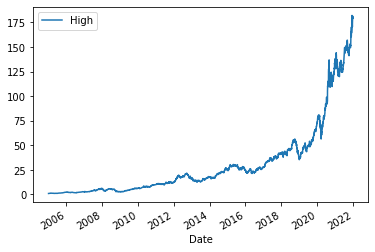

In [13]:
# Highをグラフ化するためにカラム抽出を行う
df_new = df[['High']]
#時系列の折れ線グラフを作成 -> 꺾은선그래프
df_new.plot(kind='line')

<AxesSubplot:xlabel='Date'>

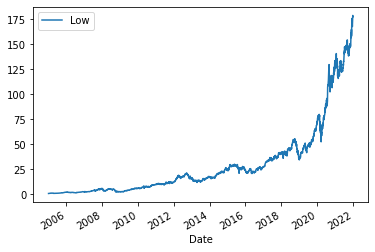

In [14]:
# Lowをグラフ化するためにカラム抽出を行う
df_new = df[['Low']]
#時系列の折れ線グラフを作成 -> 꺾은선그래프
df_new.plot(kind='line')

<AxesSubplot:xlabel='Date'>

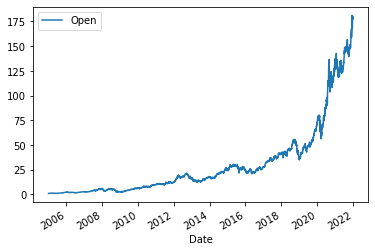

In [15]:
# Openをグラフ化するためにカラム抽出を行う
df_new = df[['Open']]
#時系列の折れ線グラフを作成 -> 꺾은선그래프
df_new.plot(kind='line')

<AxesSubplot:xlabel='Date'>

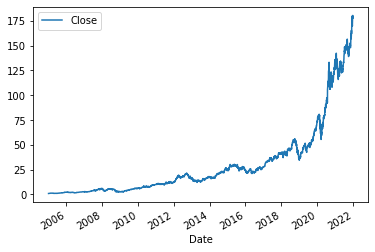

In [16]:
# Closeをグラフ化するためにカラム抽出を行う
df_new = df[['Close']]
#時系列の折れ線グラフを作成 -> 꺾은선그래프
df_new.plot(kind='line')

<AxesSubplot:xlabel='Date'>

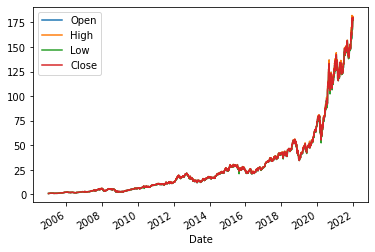

In [17]:
# High, Low, Open, Closeをグラフ化するためにカラム抽出を行う
df_new = df[['Open', 'High', 'Low', 'Close']]
#時系列の折れ線グラフを作成 -> 꺾은선그래프
df_new.plot(kind='line')

In [18]:
#終値の前日比率（本日の終値が前日の初値から何％変化したかを表す値 :（今日の終値 - 前日の終値）/前日の終値）
df_shift = df.shift(1)
df_shift


,weeks,weekday,High,Low,Open,Close,Up
Date,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,-11.0,0.0,0.9967,0.9585,0.9930,0.9687,1.0
2005-01-05,-11.0,1.0,1.0023,0.9640,0.9760,0.9788,1.0
2005-01-06,-11.0,2.0,0.9988,0.9788,0.9788,0.9875,1.0
2005-01-07,-11.0,3.0,0.9935,0.9693,0.9921,0.9881,1.0
...,...,...,...,...,...,...,...
2021-12-27,874.0,3.0,176.8499,175.2700,175.8500,176.2800,1.0
2021-12-28,875.0,0.0,180.4200,177.0700,177.0850,180.3300,0.0
2021-12-29,875.0,1.0,181.3300,178.5300,180.1600,179.2900,1.0


In [19]:
df['Close_ratio'] = (df['Close'] - df_shift['Close']) / df_shift['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio
Date,,,,,,,,
2005-01-03,-11,0,0.9967,0.9585,0.9930,0.9687,1,NaN
2005-01-04,-11,1,1.0023,0.9640,0.9760,0.9788,1,0.010426
2005-01-05,-11,2,0.9988,0.9788,0.9788,0.9875,1,0.008888
2005-01-06,-11,3,0.9935,0.9693,0.9921,0.9881,1,0.000608
2005-01-07,-11,4,1.0658,0.9916,0.9958,1.0601,0,0.072867
...,...,...,...,...,...,...,...,...
2021-12-27,875,0,180.4200,177.0700,177.0850,180.3300,0,0.022975
2021-12-28,875,1,181.3300,178.5300,180.1600,179.2900,1,-0.005767
2021-12-29,875,2,180.6300,178.1400,179.3300,179.3800,0,0.000502


In [20]:
#始値・終値の差分
df['Body'] = df['Open'] - df['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body
Date,,,,,,,,,
2005-01-03,-11,0,0.9967,0.9585,0.9930,0.9687,1,NaN,0.0243
2005-01-04,-11,1,1.0023,0.9640,0.9760,0.9788,1,0.010426,-0.0028
2005-01-05,-11,2,0.9988,0.9788,0.9788,0.9875,1,0.008888,-0.0087
2005-01-06,-11,3,0.9935,0.9693,0.9921,0.9881,1,0.000608,0.0040
2005-01-07,-11,4,1.0658,0.9916,0.9958,1.0601,0,0.072867,-0.0643
...,...,...,...,...,...,...,...,...,...
2021-12-27,875,0,180.4200,177.0700,177.0850,180.3300,0,0.022975,-3.2450
2021-12-28,875,1,181.3300,178.5300,180.1600,179.2900,1,-0.005767,0.8700
2021-12-29,875,2,180.6300,178.1400,179.3300,179.3800,0,0.000502,-0.0500


## 株価予測_LSTM ver.1で作成する予測モデルのコンセプト

#### やりたいこと 月曜日から木曜日までの情報をもとに、金曜日の初まり値が上がるか下がるかの予測モデルの作成

In [21]:
# 週番号をリストに格納
list_weeks = []
list_weeks = df['weeks'].unique()
list_weeks

array([-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
         2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 16

In [22]:
# 各週ごとの日数を入力
df['week_days'] = 0
for i in list_weeks:
    df['week_days'][df['weeks'] == i] = len(df[df['weeks'] == i])
    
df

/var/folders/g5/jlzp3hhs653_qdq2kmf35jbh0000gn/T/ipykernel_60730/2838752192.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week_days'][df['weeks'] == i] = len(df[df['weeks'] == i])


,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2005-01-03,-11,0,0.9967,0.9585,0.9930,0.9687,1,NaN,0.0243,5
2005-01-04,-11,1,1.0023,0.9640,0.9760,0.9788,1,0.010426,-0.0028,5
2005-01-05,-11,2,0.9988,0.9788,0.9788,0.9875,1,0.008888,-0.0087,5
2005-01-06,-11,3,0.9935,0.9693,0.9921,0.9881,1,0.000608,0.0040,5
2005-01-07,-11,4,1.0658,0.9916,0.9958,1.0601,0,0.072867,-0.0643,5
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,875,0,180.4200,177.0700,177.0850,180.3300,0,0.022975,-3.2450,5
2021-12-28,875,1,181.3300,178.5300,180.1600,179.2900,1,-0.005767,0.8700,5
2021-12-29,875,2,180.6300,178.1400,179.3300,179.3800,0,0.000502,-0.0500,5


In [23]:
#　月曜日〜金曜日まで5日分データがある週だけデータを取り出します
df = df[df['week_days'] == 5]
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2005-01-03,-11,0,0.9967,0.9585,0.9930,0.9687,1,NaN,0.0243,5
2005-01-04,-11,1,1.0023,0.9640,0.9760,0.9788,1,0.010426,-0.0028,5
2005-01-05,-11,2,0.9988,0.9788,0.9788,0.9875,1,0.008888,-0.0087,5
2005-01-06,-11,3,0.9935,0.9693,0.9921,0.9881,1,0.000608,0.0040,5
2005-01-07,-11,4,1.0658,0.9916,0.9958,1.0601,0,0.072867,-0.0643,5
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,875,0,180.4200,177.0700,177.0850,180.3300,0,0.022975,-3.2450,5
2021-12-28,875,1,181.3300,178.5300,180.1600,179.2900,1,-0.005767,0.8700,5
2021-12-29,875,2,180.6300,178.1400,179.3300,179.3800,0,0.000502,-0.0500,5


In [24]:
# 金曜日（4）を予測したいので、4のカラムの削除をします
df = df[df['weekday'] != 4]
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2005-01-03,-11,0,0.9967,0.9585,0.9930,0.9687,1,NaN,0.0243,5
2005-01-04,-11,1,1.0023,0.9640,0.9760,0.9788,1,0.010426,-0.0028,5
2005-01-05,-11,2,0.9988,0.9788,0.9788,0.9875,1,0.008888,-0.0087,5
2005-01-06,-11,3,0.9935,0.9693,0.9921,0.9881,1,0.000608,0.0040,5
2005-01-10,-10,0,1.0825,1.0392,1.0701,1.0559,0,-0.003962,0.0142,5
...,...,...,...,...,...,...,...,...,...,...
2021-12-16,873,3,181.1400,170.7500,179.2800,172.2600,0,-0.039264,7.0200,5
2021-12-27,875,0,180.4200,177.0700,177.0850,180.3300,0,0.022975,-3.2450,5
2021-12-28,875,1,181.3300,178.5300,180.1600,179.2900,1,-0.005767,0.8700,5


In [25]:
# 不要カラムの削除と並び替え
df = df[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body', 'Up']]
df

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2005-01-03,0,0.9967,0.9585,0.9930,0.9687,NaN,0.0243,1
2005-01-04,1,1.0023,0.9640,0.9760,0.9788,0.010426,-0.0028,1
2005-01-05,2,0.9988,0.9788,0.9788,0.9875,0.008888,-0.0087,1
2005-01-06,3,0.9935,0.9693,0.9921,0.9881,0.000608,0.0040,1
2005-01-10,0,1.0825,1.0392,1.0701,1.0559,-0.003962,0.0142,0
...,...,...,...,...,...,...,...,...
2021-12-16,3,181.1400,170.7500,179.2800,172.2600,-0.039264,7.0200,0
2021-12-27,0,180.4200,177.0700,177.0850,180.3300,0.022975,-3.2450,0
2021-12-28,1,181.3300,178.5300,180.1600,179.2900,-0.005767,0.8700,1


## 学習データと検証データに分割

#### 学習データ（2006/1/1~2019/12/31）をdf_train、検証データ(2020/1/1~2021/12/31)をdf_valに分割します。

In [26]:
# 学習データ（2006~2019）をdf_trainに入力
df_train = df['2006-01-01' : '2019-12-31']
df_train

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2006-01-09,0,2.3637,2.3193,2.3515,2.3286,-0.003040,0.0229,1
2006-01-10,1,2.5070,2.3220,2.3344,2.4760,0.063300,-0.1416,1
2006-01-11,2,2.5963,2.5290,2.5671,2.5688,0.037480,-0.0017,1
2006-01-12,3,2.6458,2.5604,2.6013,2.5810,0.004749,0.0203,1
2006-01-23,0,2.4361,2.3266,2.3315,2.3783,0.021036,-0.0468,0
...,...,...,...,...,...,...,...,...
2019-12-12,3,67.1410,65.8520,65.9670,66.8720,0.002534,-0.9050,1
2019-12-16,0,69.1710,68.2300,68.2340,68.9430,0.017128,-0.7090,1
2019-12-17,1,69.4130,68.6800,68.8710,69.0750,0.001915,-0.2040,0


In [27]:
# 検証データ(2021)に分割
df_val = df['2020-01-01' : ]
df_val

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2020-01-06,0,73.891,72.119,72.369,73.851,0.007916,-1.482,0
2020-01-07,1,74.125,73.283,73.861,73.508,-0.004644,0.353,1
2020-01-08,2,74.995,73.201,73.203,74.688,0.016053,-1.485,1
2020-01-09,3,76.467,75.432,75.684,76.278,0.021289,-0.594,1
2020-01-13,0,78.108,76.646,76.769,78.081,0.021401,-1.312,0
...,...,...,...,...,...,...,...,...
2021-12-16,3,181.140,170.750,179.280,172.260,-0.039264,7.020,0
2021-12-27,0,180.420,177.070,177.085,180.330,0.022975,-3.245,0
2021-12-28,1,181.330,178.530,180.160,179.290,-0.005767,0.870,1


In [28]:
# 学習データを説明変数（X_train）と目的変数（y_train）に分ける
X_train = df_train[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body']]
y_train = df_train['Up']

#学習データの説明変数と目的変数を確認
print(X_train)
print(y_train)

            weekday     High      Low     Open    Close  Close_ratio    Body
Date                                                                        
2006-01-09        0   2.3637   2.3193   2.3515   2.3286    -0.003040  0.0229
2006-01-10        1   2.5070   2.3220   2.3344   2.4760     0.063300 -0.1416
2006-01-11        2   2.5963   2.5290   2.5671   2.5688     0.037480 -0.0017
2006-01-12        3   2.6458   2.5604   2.6013   2.5810     0.004749  0.0203
2006-01-23        0   2.4361   2.3266   2.3315   2.3783     0.021036 -0.0468
...             ...      ...      ...      ...      ...          ...     ...
2019-12-12        3  67.1410  65.8520  65.9670  66.8720     0.002534 -0.9050
2019-12-16        0  69.1710  68.2300  68.2340  68.9430     0.017128 -0.7090
2019-12-17        1  69.4130  68.6800  68.8710  69.0750     0.001915 -0.2040
2019-12-18        2  69.4440  68.7600  68.9280  68.9140    -0.002331  0.0140
2019-12-19        3  69.2650  68.7180  68.8550  68.9810     0.000972 -0.1260

In [29]:
# 検証データを説明変数（X_val）と目的変数（y_val）に分ける
X_val = df_val[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body']]
y_val = df_val['Up']

# 検証データの説明変数と目的変数を確認
print(X_val)
print(y_val)

            weekday     High      Low     Open    Close  Close_ratio   Body
Date                                                                       
2020-01-06        0   73.891   72.119   72.369   73.851     0.007916 -1.482
2020-01-07        1   74.125   73.283   73.861   73.508    -0.004644  0.353
2020-01-08        2   74.995   73.201   73.203   74.688     0.016053 -1.485
2020-01-09        3   76.467   75.432   75.684   76.278     0.021289 -0.594
2020-01-13        0   78.108   76.646   76.769   78.081     0.021401 -1.312
...             ...      ...      ...      ...      ...          ...    ...
2021-12-16        3  181.140  170.750  179.280  172.260    -0.039264  7.020
2021-12-27        0  180.420  177.070  177.085  180.330     0.022975 -3.245
2021-12-28        1  181.330  178.530  180.160  179.290    -0.005767  0.870
2021-12-29        2  180.630  178.140  179.330  179.380     0.000502 -0.050
2021-12-30        3  180.570  178.090  179.470  178.200    -0.006578  1.270

[348 rows x

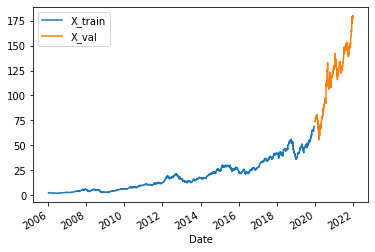

<Figure size 1440x1080 with 0 Axes>

In [30]:
# 学習データと検証データの終値（Close）の折れ線グラフ作成
X_train['Close'].plot(kind='line')
X_val['Close'].plot(kind='line')

# グラフの凡例を設定
plt.legend(['X_train', 'X_val'])

# グラフ表示
plt.figure(figsize=(20,15))
plt.show()

설명 변수와 목적 변수의 데이터 양을 정렬하기 위해 월요일부터 목요일까지 한 세트로 처리합니다. 또한 주가를 빼는 기간에 따라 금액과 변동량이 다르기 때문에 데이터를 정규화하는 함수를 작성합니다. LSTM에서는 Numpy 배열로 처리하므로 Numpy 배열로 처리합니다.

In [31]:
# 4日ごとにデータを抜き出して、標準化とNumpy配列に変換する関数（SS_to_np）の定義 -> StandardScaler
def SS_to_np(df):
    df_list = []
    df = np.array(df) # 入力されたdfをnumpy配列に変換する
    for i in range(0, len(df) -3, 4): # 最後の4日分のデータまで以下の処理を繰り返す
        df_s = df[i:i+4] # 4日ずつのデータを抜き出してdf_sに入力する
        SS = StandardScaler() # SSとしてインスタンス化する
        df_SS = SS.fit_transform(df_s) # 標準化した結果を格納
        df_list.append(df_SS) # 標準化をおこなった結果をappendメソッドで追加
    return np.array(df_list) # 最後の処理が終了したらdf_listをnumpy配列で出力する

In [32]:
# 学習データと検証データの説明変数に変換（SS_to_np）を実行
X_train_np_array = SS_to_np(X_train)
X_val_np_array = SS_to_np(X_val)

# 学習データと検証データのデータの形を確認
print(X_train_np_array.shape) # 2268日分のrowsが567に
print(X_val_np_array.shape) # 320日分あったrowsが80に

(603, 4, 7)
(87, 4, 7)


In [33]:
# 学習データと検証データの目的変数を確認
print(X_train)
print(X_val)

            weekday     High      Low     Open    Close  Close_ratio    Body
Date                                                                        
2006-01-09        0   2.3637   2.3193   2.3515   2.3286    -0.003040  0.0229
2006-01-10        1   2.5070   2.3220   2.3344   2.4760     0.063300 -0.1416
2006-01-11        2   2.5963   2.5290   2.5671   2.5688     0.037480 -0.0017
2006-01-12        3   2.6458   2.5604   2.6013   2.5810     0.004749  0.0203
2006-01-23        0   2.4361   2.3266   2.3315   2.3783     0.021036 -0.0468
...             ...      ...      ...      ...      ...          ...     ...
2019-12-12        3  67.1410  65.8520  65.9670  66.8720     0.002534 -0.9050
2019-12-16        0  69.1710  68.2300  68.2340  68.9430     0.017128 -0.7090
2019-12-17        1  69.4130  68.6800  68.8710  69.0750     0.001915 -0.2040
2019-12-18        2  69.4440  68.7600  68.9280  68.9140    -0.002331  0.0140
2019-12-19        3  69.2650  68.7180  68.8550  68.9810     0.000972 -0.1260

In [34]:
# 学習データ、検証データの目的変数の間引き・週の4日目（木曜日）のデータだけ抜き出す
y_train_new = y_train[3::4]
y_val_new = y_val[3::4]

In [35]:
# 間引き後の学習データと検証データ
print(len(y_train_new))
print(len(y_val_new))

603
87


## LSTM構築

In [36]:
# LSTM構築とコンパイル関数
def lstm_comp(df):
  # 入力層/中間層/出力層のネットワーク構築
  model = Sequential()
  model.add(LSTM(256, activation='relu', batch_input_shape=(None, df.shape[1], df.shape[2])))
  model.add(Dropout(0.2))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  # ネットワークのコンパイル
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
  return model

#### 時系列分割交差検証を作成します

In [37]:
# 時系列分割交差検証 -> 시계열 분할 교차 검증
valid_scores = [] # 4回分の交差検証の結果を代入する空のリストを作成 -> 4회분의 교차 검증의 결과를 대입하는 빈 리스트를 작성
tscv = TimeSeriesSplit(n_splits=4) # TimeSeriesSplitのインスタンス化を行い変数に代入する

In [38]:
# for文で交差検証を4回行う、、splitメソッドを用いて学習データを分割して交差検証用の学習データと検証データを作成する
for fold, (train_indices, valid_indices) in enumerate(tscv.split(X_train_np_array)):
    X_train, X_valid = X_train_np_array[train_indices], X_train_np_array[valid_indices]
    y_train, y_valid = y_train_new[train_indices], y_train_new[valid_indices]

    # LSTM構築とコンパイル関数にX_trainを渡し、変数modelに代入
    model = lstm_comp(X_train)

    # モデル学習
    model.fit(X_train, y_train, epochs=10, batch_size=64)

    # 予測
    y_valid_pred = model.predict(X_valid)

    # 予測結果の予測結果の2値化
    y_valid_pred = np.where(y_valid_pred < 0.5, 0, 1)

    # 予測精度の算出と表示
    score = accuracy_score(y_valid, y_valid_pred)
    print(f'fold {fold} MAE: {score}')

    # 予測精度のスコアをリストに格納
    valid_scores.append(score)

Epoch 1/10


2022-03-18 16:42:28.066010: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 1s 12ms/step - loss: 0.6940 - accuracy: 0.4878
Epoch 2/10
2/2 [==============================] - 0s 9ms/step - loss: 0.6871 - accuracy: 0.5691
Epoch 3/10
2/2 [==============================] - 0s 12ms/step - loss: 0.6828 - accuracy: 0.5691
Epoch 4/10
2/2 [==============================] - 0s 11ms/step - loss: 0.6761 - accuracy: 0.5691
Epoch 5/10
2/2 [==============================] - 0s 11ms/step - loss: 0.6734 - accuracy: 0.5691
Epoch 6/10
2/2 [==============================] - 0s 11ms/step - loss: 0.6735 - accuracy: 0.5691
Epoch 7/10
2/2 [==============================] - 0s 12ms/step - loss: 0.6680 - accuracy: 0.5691
Epoch 8/10
2/2 [==============================] - 0s 12ms/step - loss: 0.6688 - accuracy: 0.5772
Epoch 9/10
2/2 [==============================] - 0s 10ms/step - loss: 0.6678 - accuracy: 0.5935
Epoch 10/10
2/2 [==============================] - 0s 9ms/step - loss: 0.6613 - accuracy: 0.6098
fold 0 MAE: 0.55
Epoch 1/10
4/4 [=========

In [39]:
print(f'valid_scores: {valid_scores}')
cv_score = np.mean(valid_scores) # cross value
print(f'CV score: {cv_score}')

valid_scores: [0.55, 0.575, 0.5416666666666666, 0.5416666666666666]
CV score: 0.5520833333333333


In [40]:
# LSTM構築とコンパイル関数にX_train_np_arrayを渡し、変数変数modelに代入
model = lstm_comp(X_train_np_array)

In [41]:
# モデルの学習の実行
result = model.fit(X_train_np_array, y_train_new, epochs=10, batch_size=64)

Epoch 1/10
10/10 [==============================] - 1s 14ms/step - loss: 0.6898 - accuracy: 0.5108
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 0.6845 - accuracy: 0.5522
Epoch 3/10
10/10 [==============================] - 0s 16ms/step - loss: 0.6803 - accuracy: 0.5688
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 0.6766 - accuracy: 0.5904
Epoch 5/10
10/10 [==============================] - 0s 17ms/step - loss: 0.6752 - accuracy: 0.5937
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 0.6752 - accuracy: 0.5854
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.6762 - accuracy: 0.5688
Epoch 8/10
10/10 [==============================] - 0s 12ms/step - loss: 0.6711 - accuracy: 0.5987
Epoch 9/10
10/10 [==============================] - 0s 13ms/step - loss: 0.6698 - accuracy: 0.6036
Epoch 10/10
10/10 [==============================] - 0s 13ms/step - loss: 0.6694 - accuracy: 0.6153


In [42]:
# 作成したモデルより検証データを用いて予測を行う
pred = model.predict(X_val_np_array)
pred[:10]

array([[0.58274794],
       [0.4685266 ],
       [0.56301326],
       [0.6183482 ],
       [0.5994464 ],
       [0.4029433 ],
       [0.5939517 ],
       [0.5329289 ],
       [0.46139732],
       [0.55765593]], dtype=float32)

In [43]:
# 予測結果を0もしくは1に修正（0.5を境にして、１に近いほど株価が上昇、、0に近いほど株価が下落）
pred = np.where(pred < 0.5, 0, 1)

# 修正した予測結果の先頭先頭10件を確認
pred[:10]

array([[1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1]])

In [44]:
# 実際の結果から予測値の正解率を計算する
print('accuracy = ', accuracy_score(y_true=y_val_new, y_pred=pred))

accuracy =  0.42528735632183906


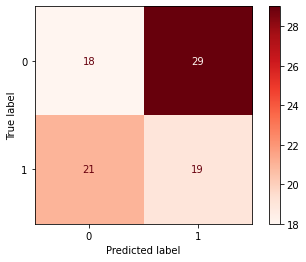

In [45]:
# 混同行列を表示
cm = confusion_matrix(y_val_new, pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)